RL policy based on the [SoloParkour: Constrained Reinforcement Learning for Visual Locomotion from Privileged Experience](https://arxiv.org/abs/2409.13678). 

# Flat Ground

## Test In Simulation

In [1]:
from Go2Py.robot.fsm import FSM
from Go2Py.robot.remote import KeyboardRemote, XBoxRemote
from Go2Py.robot.safety import SafetyHypervisor
from Go2Py.sim.mujoco import Go2Sim
from Go2Py.control.cat import *
import torch

pygame 2.6.1 (SDL 2.28.4, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
robot = Go2Sim(dt = 0.001)

In [3]:
remote = XBoxRemote() # KeyboardRemote()
robot.sitDownReset()
safety_hypervisor = SafetyHypervisor(robot)

Put your stick at reset and do not touch it while calibrating


In [4]:
class CaTController:
    def __init__(self, robot, remote, checkpoint):
        self.remote = remote
        self.robot = robot
        self.policy = Policy(checkpoint)
        self.command_profile = CommandInterface()
        self.agent = CaTAgent(self.command_profile, self.robot)
        self.hist_data = {}

    def init(self):
        self.obs = self.agent.reset()
        self.policy_info = {}
        self.command_profile.yaw_vel_cmd = 0.0
        self.command_profile.x_vel_cmd = 0.0
        self.command_profile.y_vel_cmd = 0.0

    def update(self, robot, remote):
        if not hasattr(self, "obs"):
            self.init()
        commands = remote.getCommands()
        self.command_profile.yaw_vel_cmd = -commands[2]
        self.command_profile.x_vel_cmd = commands[1] * 0.6
        self.command_profile.y_vel_cmd = -commands[0] * 0.6

        action = self.policy(self.obs, self.policy_info)
        self.obs, self.ret, self.done, self.info = self.agent.step(action)
        for key, value in self.info.items():
            if key in self.hist_data:
                self.hist_data[key].append(value)
            else:
                self.hist_data[key] = [value]

In [5]:
robot.getJointStates()

{'q': array([-0.02489972,  1.26249508, -2.82800513,  0.04556739,  1.25053519,
        -2.79318037, -0.3062963 ,  1.28285276, -2.82290189,  0.26406768,
         1.29357252, -2.84247318]),
 'dq': array([ 0.05639392, -0.00138966,  0.26148655, -0.06824655, -0.00160641,
         0.1753318 , -0.05681151,  0.01524675,  0.2468449 ,  0.06539485,
         0.01677717,  0.29524517]),
 'tau_est': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])}

In [6]:
from Go2Py import ASSETS_PATH 
import os
# what we tested
#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/SoloParkour/trainparamsconfigmax_epochs1500_taskenvlearnlimitsfoot_contact_force_rate60_soft_07-20-22-43.pt')
# new one
checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/SoloParkour/dof_vel_3_10-00-05-00.pt')
controller = CaTController(robot, remote, checkpoint_path)
decimation = 20
fsm = FSM(robot, remote, safety_hypervisor, control_dT=decimation * robot.dt, user_controller_callback=controller.update)

/home/Go2py/Go2Py/control/cat.py:100: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  actor_sd = torch.load(checkpoint_path, map_location="cpu")


Exported model has been tested with ONNXRuntime, and the result looks good!
p_gains: [20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20.]


In [8]:
remote.x_vel_cmd=0.6
remote.y_vel_cmd=0.0
remote.yaw_vel_cmd = 0.0

Pressing `u` on the keyboard will make the robot stand up. This is equivalent to the `L2+A` combo of the Go2 builtin state machine. After the the robot is on its feet, pressing `s` will hand over the control the RL policy. This action is equivalent to the `start` key of the builtin controller. When you want to stop, pressing `u` again will act similarly to the real robot and locks it in standing mode. Finally, pressing `u` again will command the robot to sit down.

In [7]:
fsm.close()

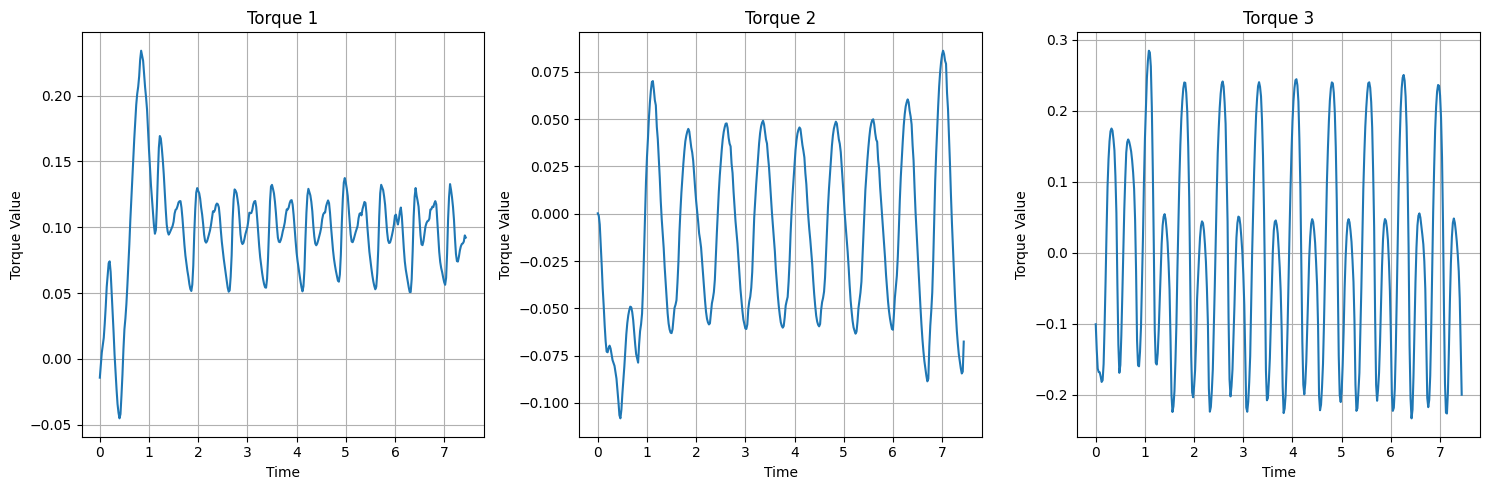

In [8]:
import matplotlib.pyplot as plt
# Assuming 'controller.hist_data["torques"]' is a dictionary with torque profiles
torques = np.array(controller.hist_data["body_linear_vel"])[:, 0, :, 0]

# Number of torque profiles
torque_nb = torques.shape[1]

# Number of rows needed for the grid, with 3 columns per row
n_cols = 3
n_rows = int(np.ceil(torque_nb / n_cols))

# Create the figure and axes for subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

# Flatten the axes array for easy indexing (in case of multiple rows)
axes = axes.flatten()

# Plot each torque profile
for i in range(torque_nb):
    axes[i].plot(np.arange(torques.shape[0]) * robot.dt * decimation, torques[:, i])
    axes[i].set_title(f'Torque {i+1}')
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Torque Value')
    axes[i].grid(True)

# Remove any empty subplots if torque_nb is not a multiple of 3
for j in range(torque_nb, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.savefig("torque_profile.png")
plt.show()

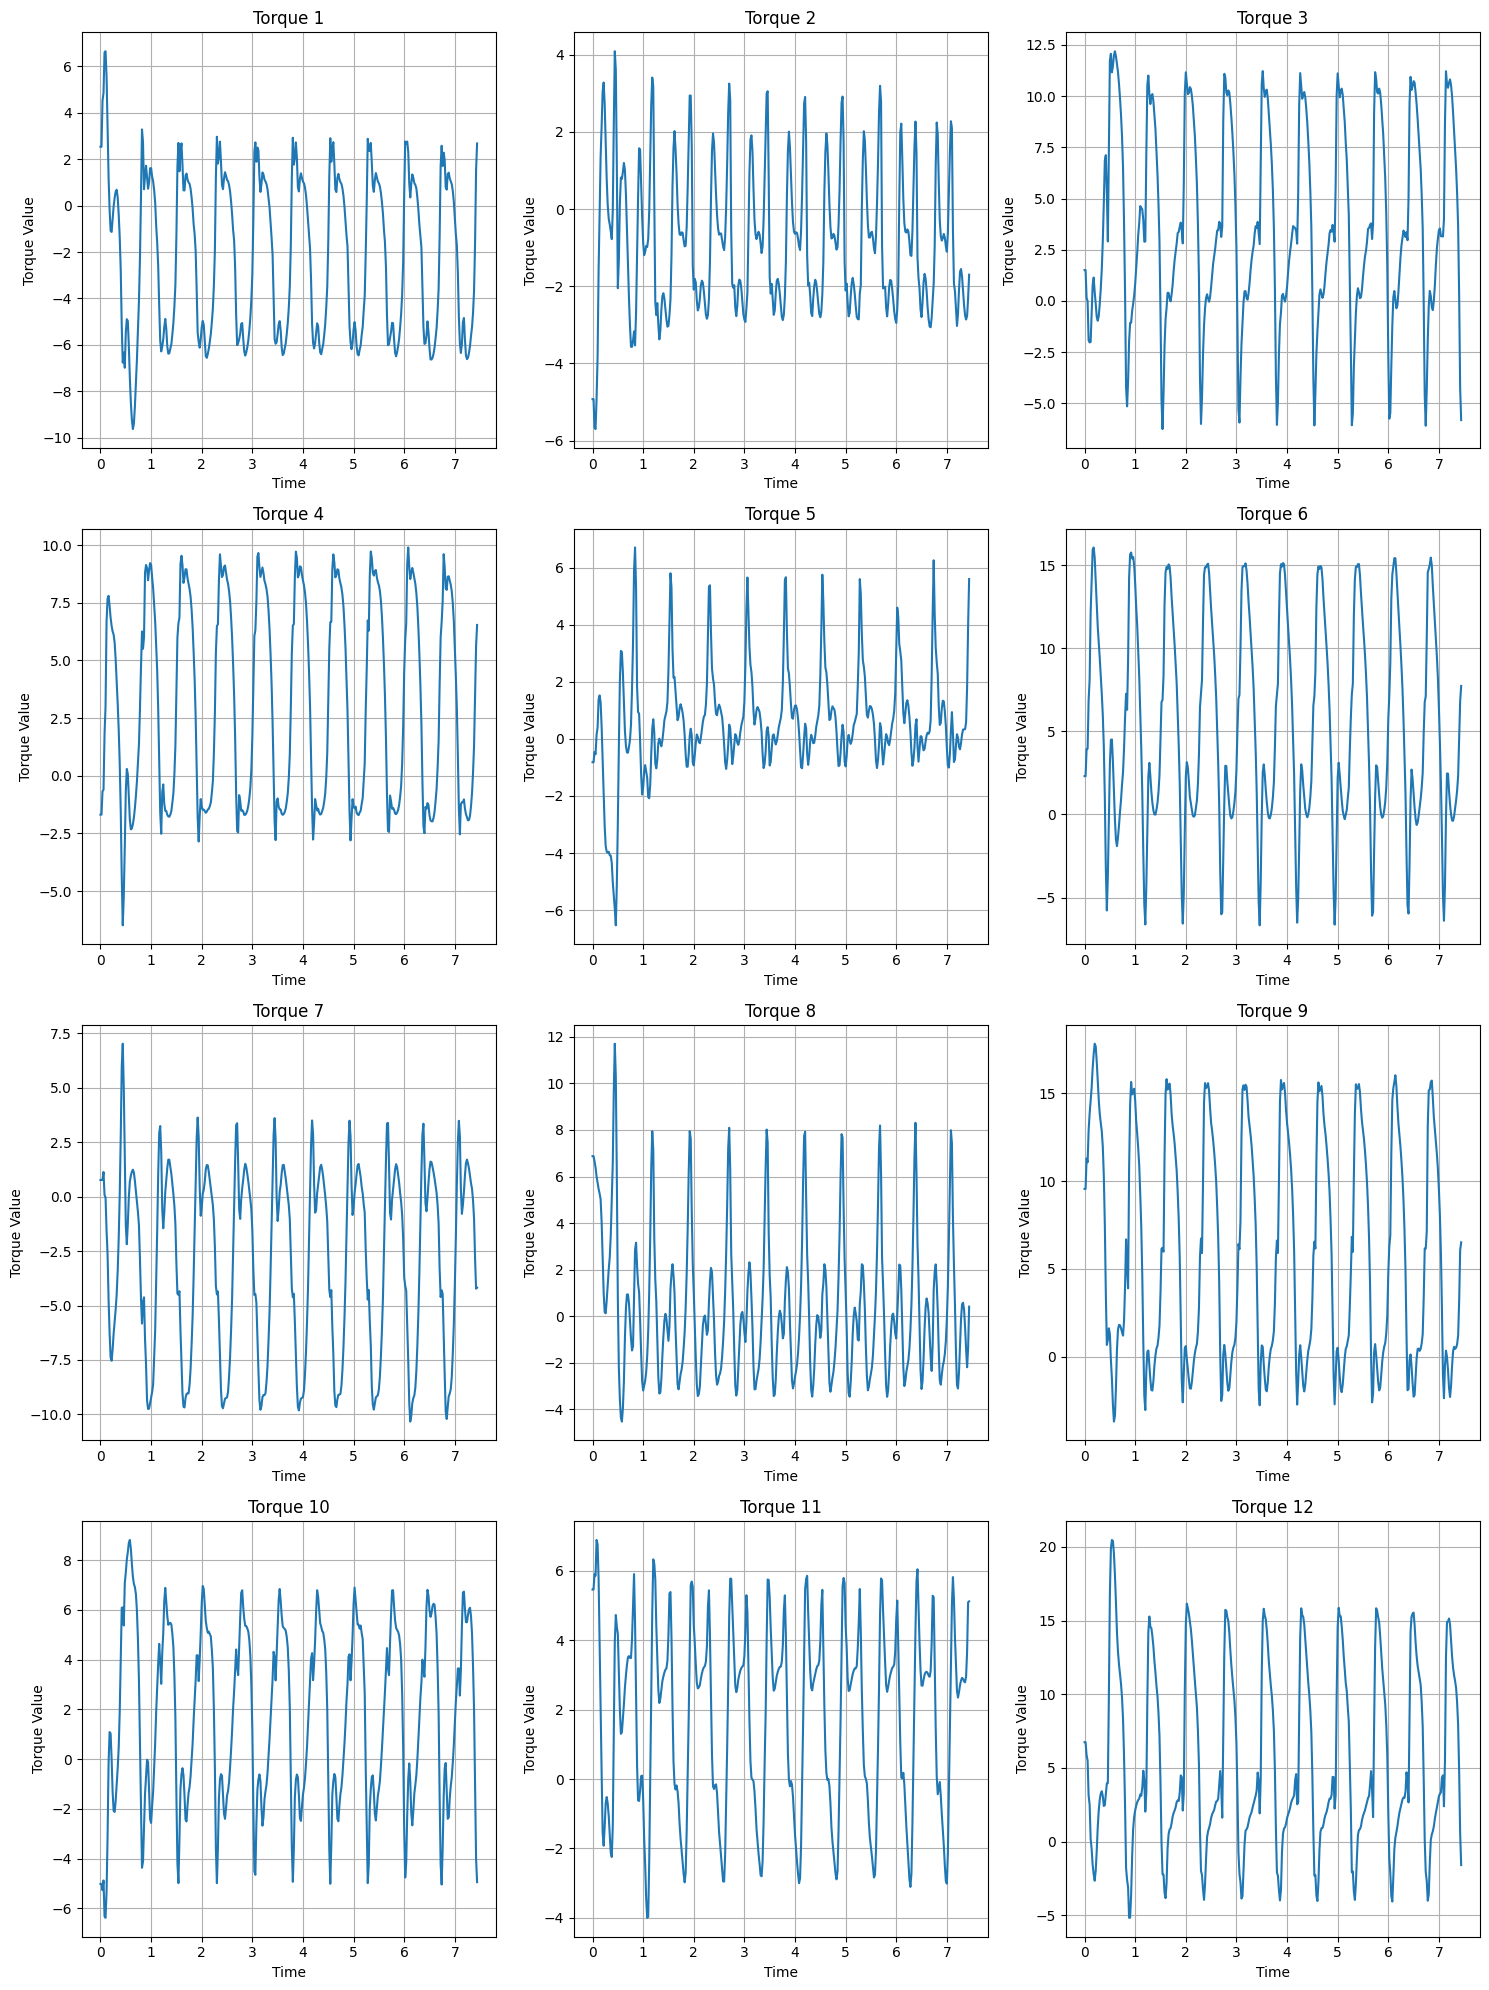

In [9]:
import matplotlib.pyplot as plt
# Assuming 'controller.hist_data["torques"]' is a dictionary with torque profiles
torques = np.array(controller.hist_data["torques"])

# Number of torque profiles
torque_nb = torques.shape[1]

# Number of rows needed for the grid, with 3 columns per row
n_cols = 3
n_rows = int(np.ceil(torque_nb / n_cols))

# Create the figure and axes for subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

# Flatten the axes array for easy indexing (in case of multiple rows)
axes = axes.flatten()

# Plot each torque profile
for i in range(torque_nb):
    axes[i].plot(np.arange(torques.shape[0]) * robot.dt * decimation, torques[:, i])
    axes[i].set_title(f'Torque {i+1}')
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Torque Value')
    axes[i].grid(True)

# Remove any empty subplots if torque_nb is not a multiple of 3
for j in range(torque_nb, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.savefig("torque_profile.png")
plt.show()

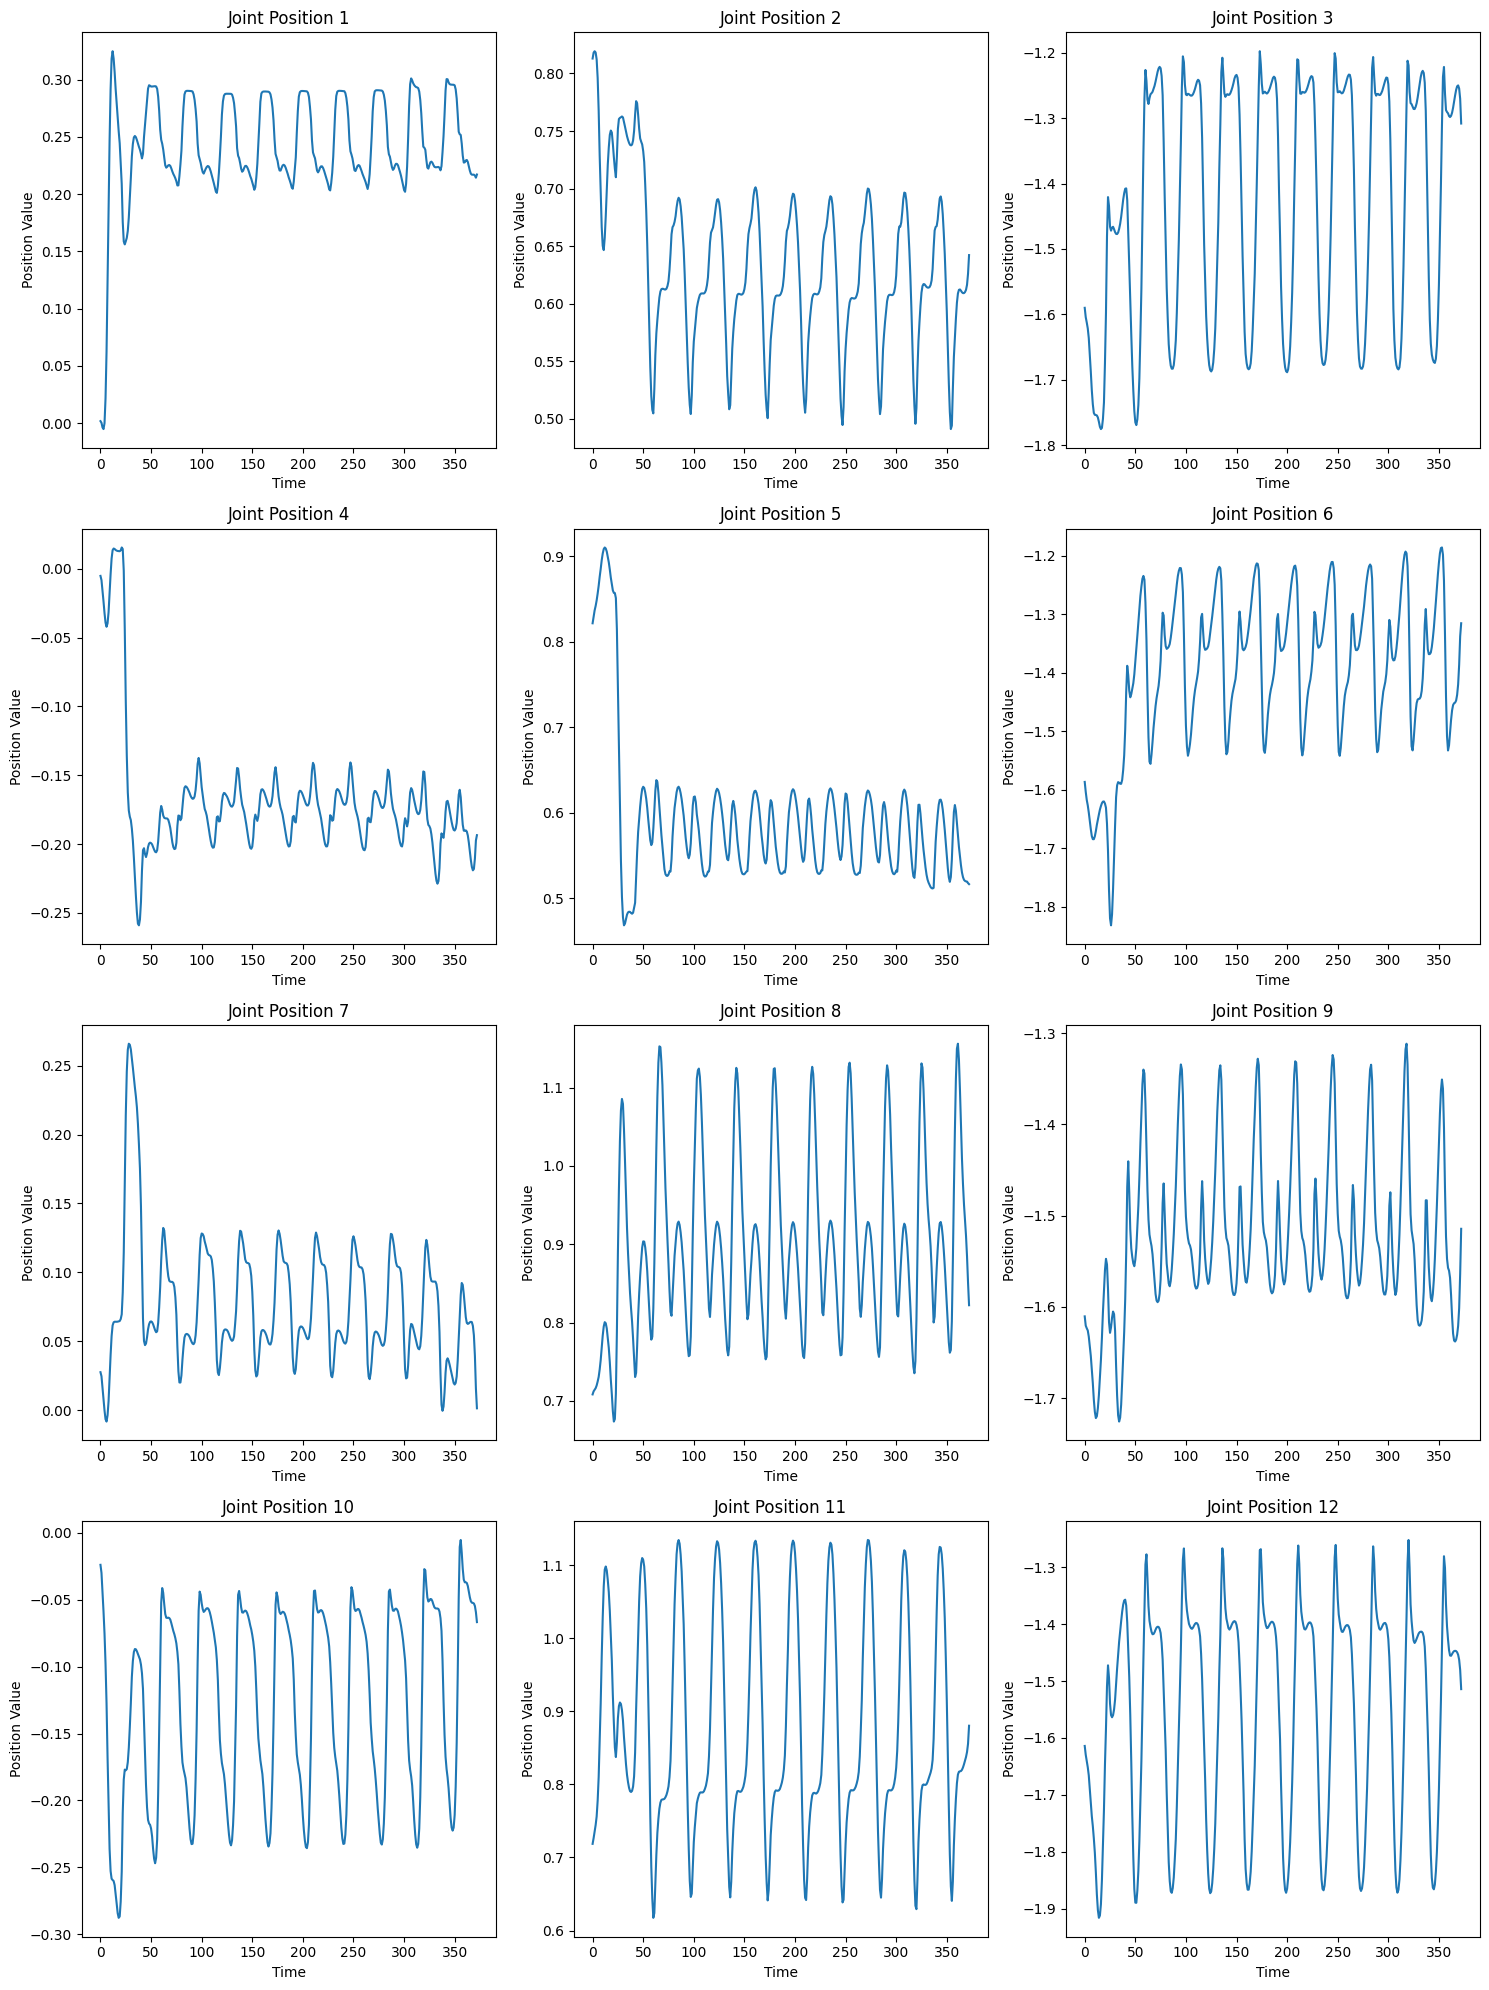

In [10]:
# Extract the joint position data for the first joint over time
joint_pos = np.array(controller.hist_data["joint_pos"])[:, 0]

# Number of data points in joint_pos
n_data_points = len(joint_pos)

# Since you're plotting only one joint, no need for multiple subplots in this case.
# But to follow the grid requirement, we'll replicate the data across multiple subplots.
# For example, let's assume you want to visualize this data 9 times in a 3x3 grid.

n_cols = 3
n_rows = int(np.ceil(torque_nb / n_cols))

# Create the figure and axes for subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

# Flatten the axes array for easy indexing (in case of multiple rows)
axes = axes.flatten()

# Plot the same joint position data in every subplot (as per grid requirement)
for i in range(n_rows * n_cols):
    axes[i].plot(joint_pos[:, i])
    axes[i].set_title(f'Joint Position {i+1}')
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Position Value')

# Adjust layout
plt.tight_layout()
plt.savefig("joint_position_profile.png")
plt.show()

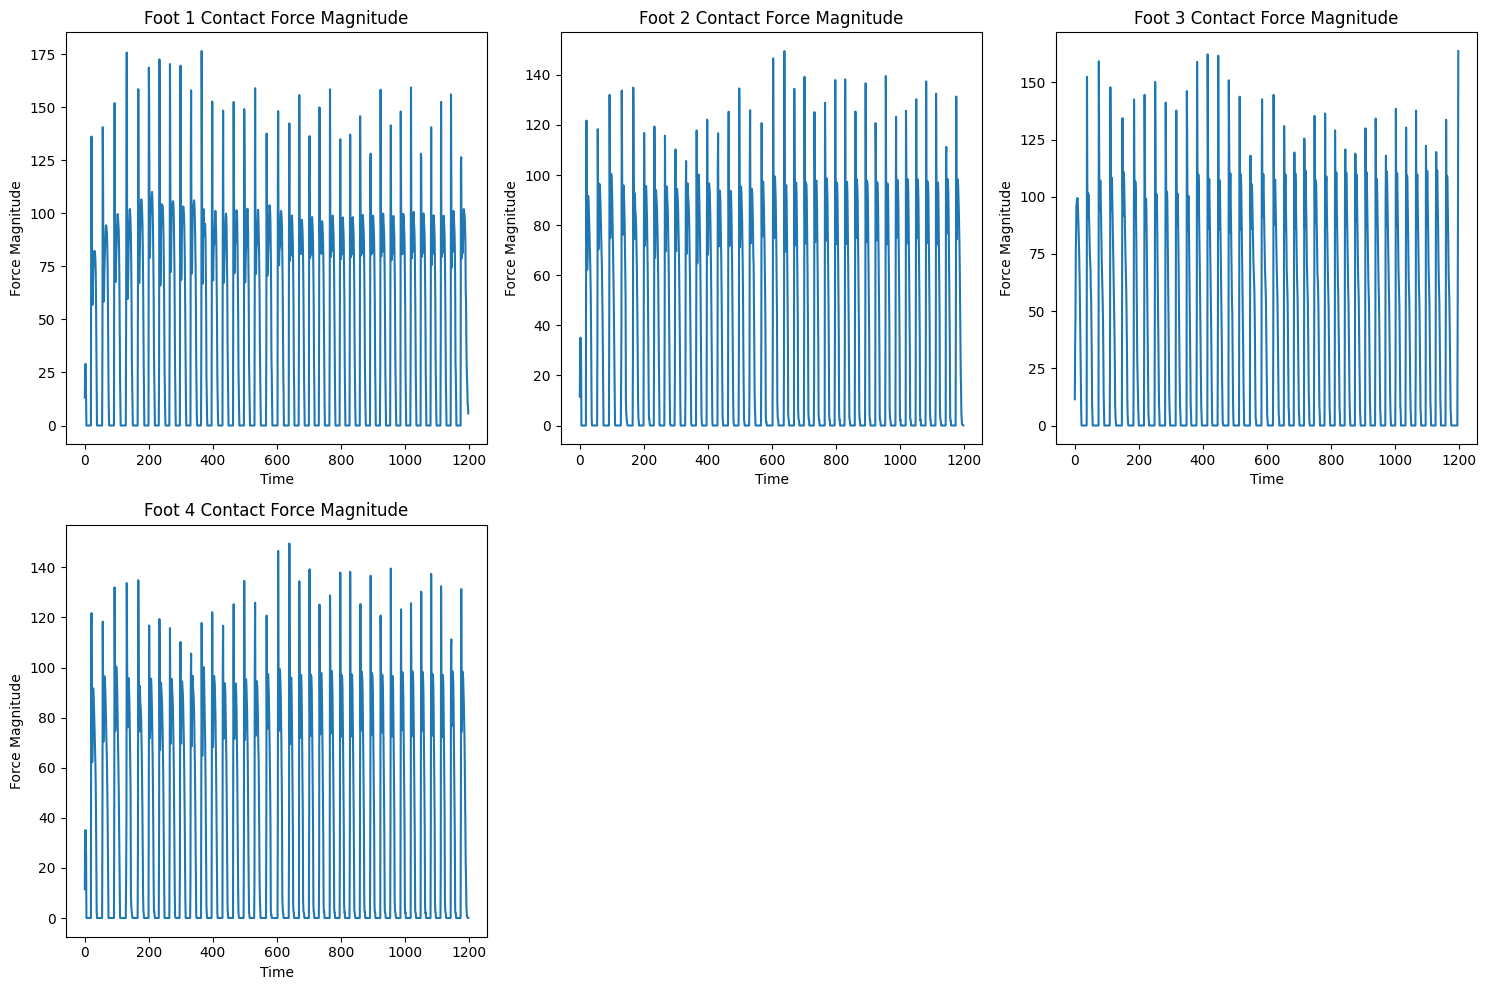

In [6]:
import matplotlib.pyplot as plt
# Assuming 'controller.hist_data["foot_contact_forces_mag"]' is a dictionary with foot contact force magnitudes
foot_contact_forces_mag = np.array(controller.hist_data["foot_contact_forces_mag"])

# Number of feet (foot_nb)
foot_nb = foot_contact_forces_mag.shape[1]

# Number of rows needed for the grid, with 3 columns per row
n_cols = 3
n_rows = int(np.ceil(foot_nb / n_cols))

# Create the figure and axes for subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

# Flatten the axes array for easy indexing (in case of multiple rows)
axes = axes.flatten()

# Plot each foot's contact force magnitude
for i in range(foot_nb):
    axes[i].plot(foot_contact_forces_mag[:, i])
    axes[i].set_title(f'Foot {i+1} Contact Force Magnitude')
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Force Magnitude')

# Remove any empty subplots if foot_nb is not a multiple of 3
for j in range(foot_nb, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.savefig("foot_contact_profile.png")
plt.show()

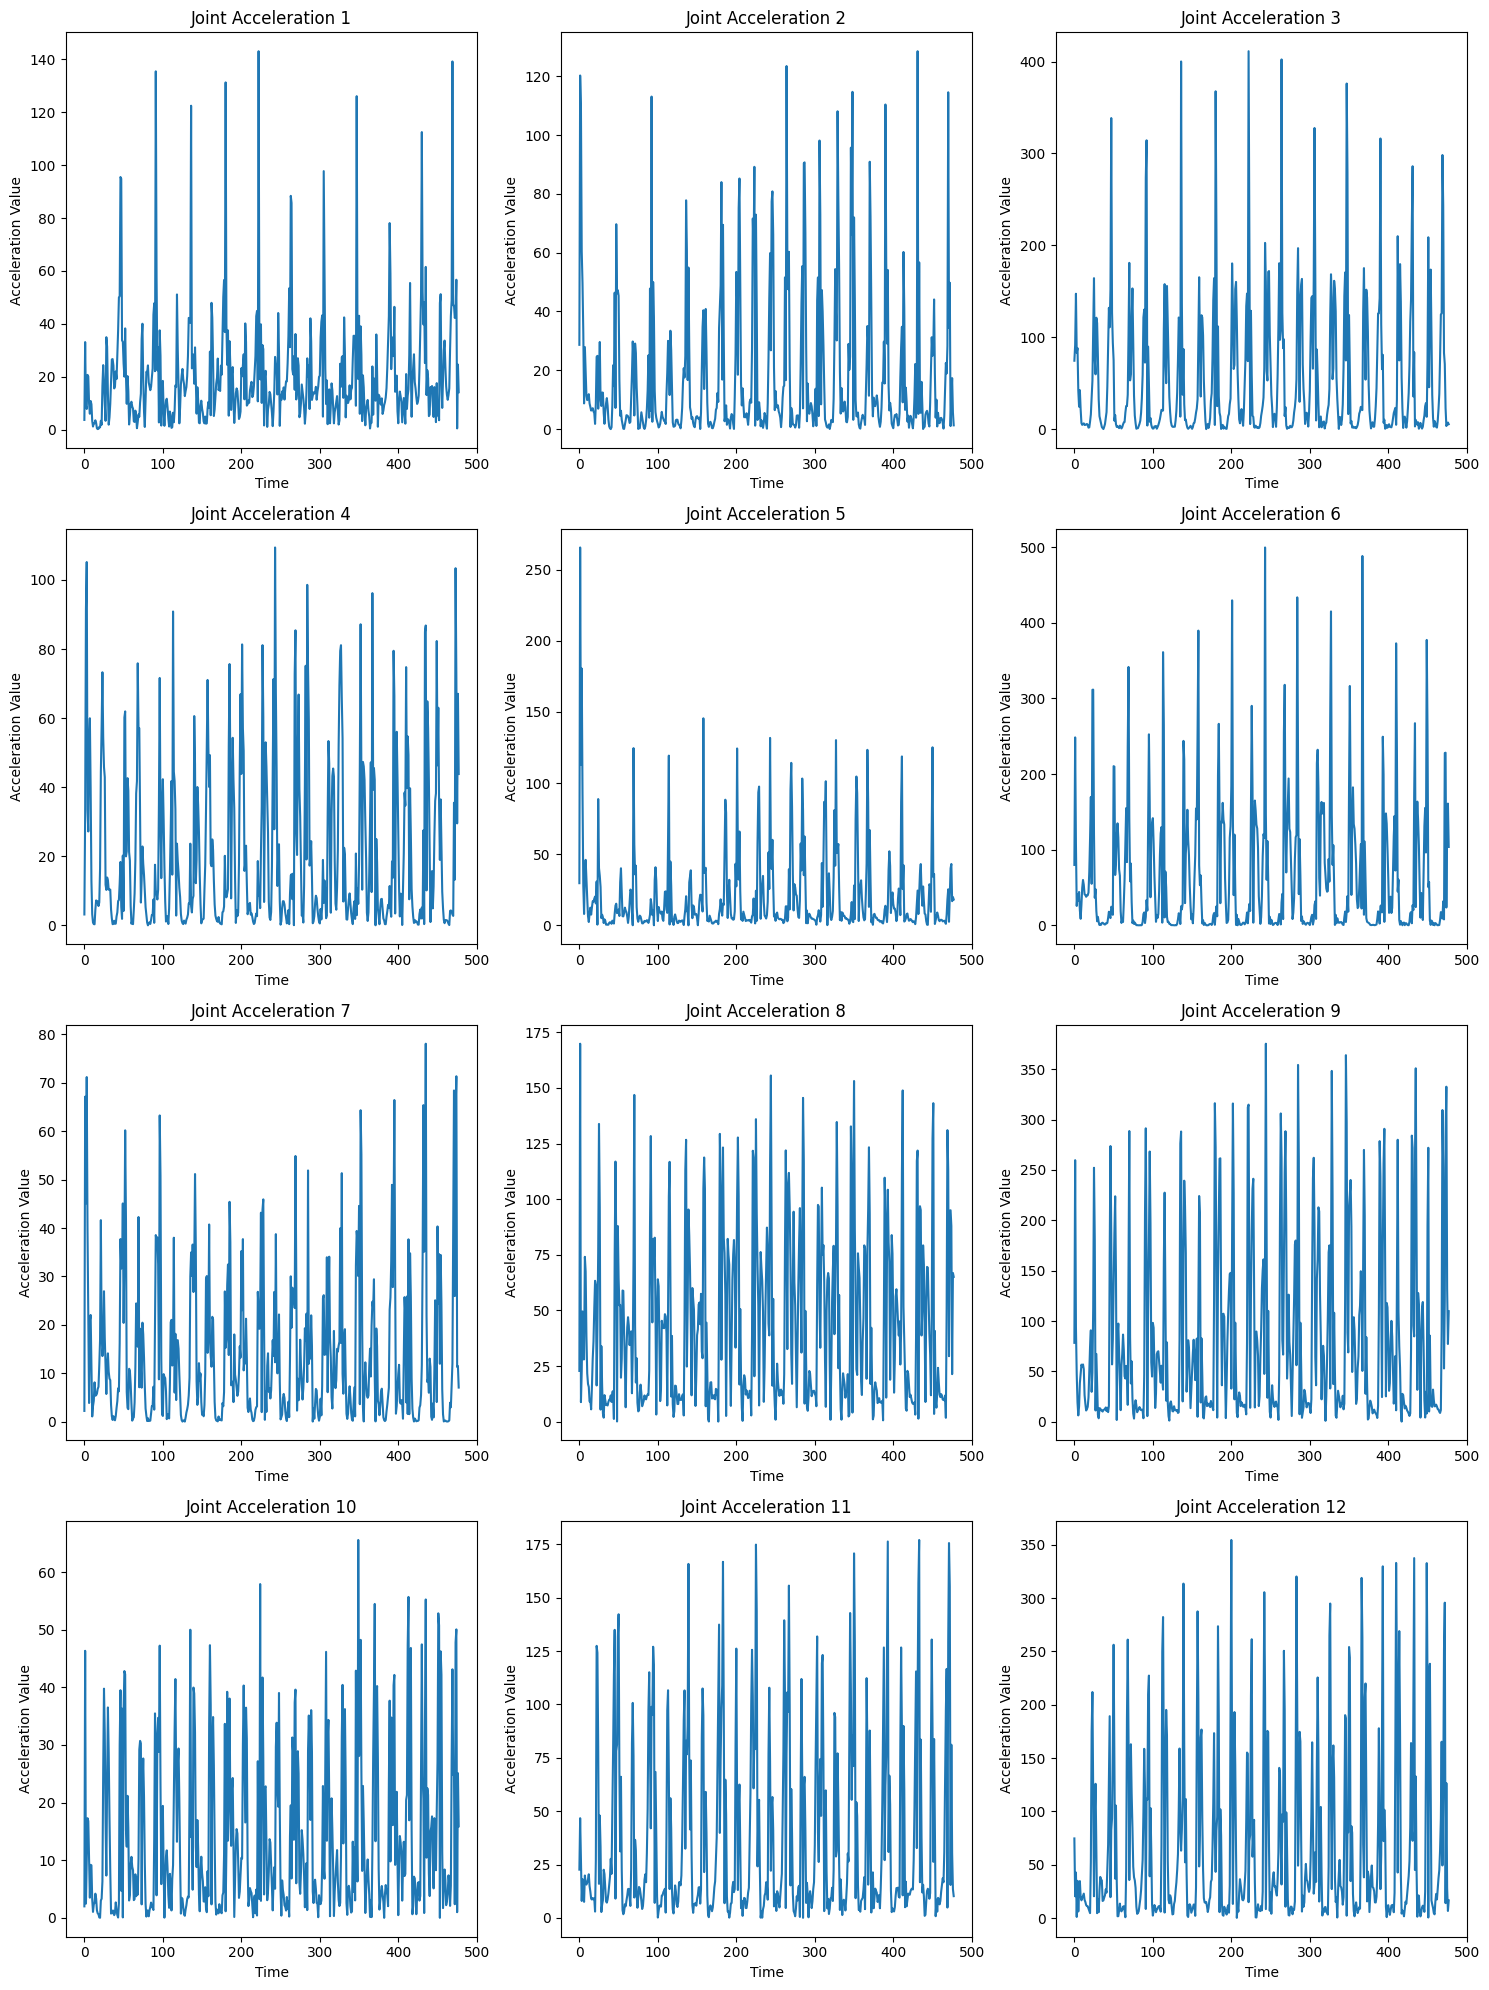

In [8]:
# Extract the joint acceleration data for the first joint over time
joint_acc = np.array(controller.hist_data["joint_acc"])[:, 0]

# Number of data points in joint_acc
n_data_points = len(joint_acc)

# Number of feet (foot_nb)
foot_nb = joint_acc.shape[1]

# Number of rows needed for the grid, with 3 columns per row
n_cols = 3
n_rows = int(np.ceil(foot_nb / n_cols))

# Create the figure and axes for subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Plot the same joint acceleration data in every subplot (as per grid requirement)
for i in range(n_rows * n_cols):
    axes[i].plot(joint_acc[:, i])
    axes[i].set_title(f'Joint Acceleration {i+1}')
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Acceleration Value')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

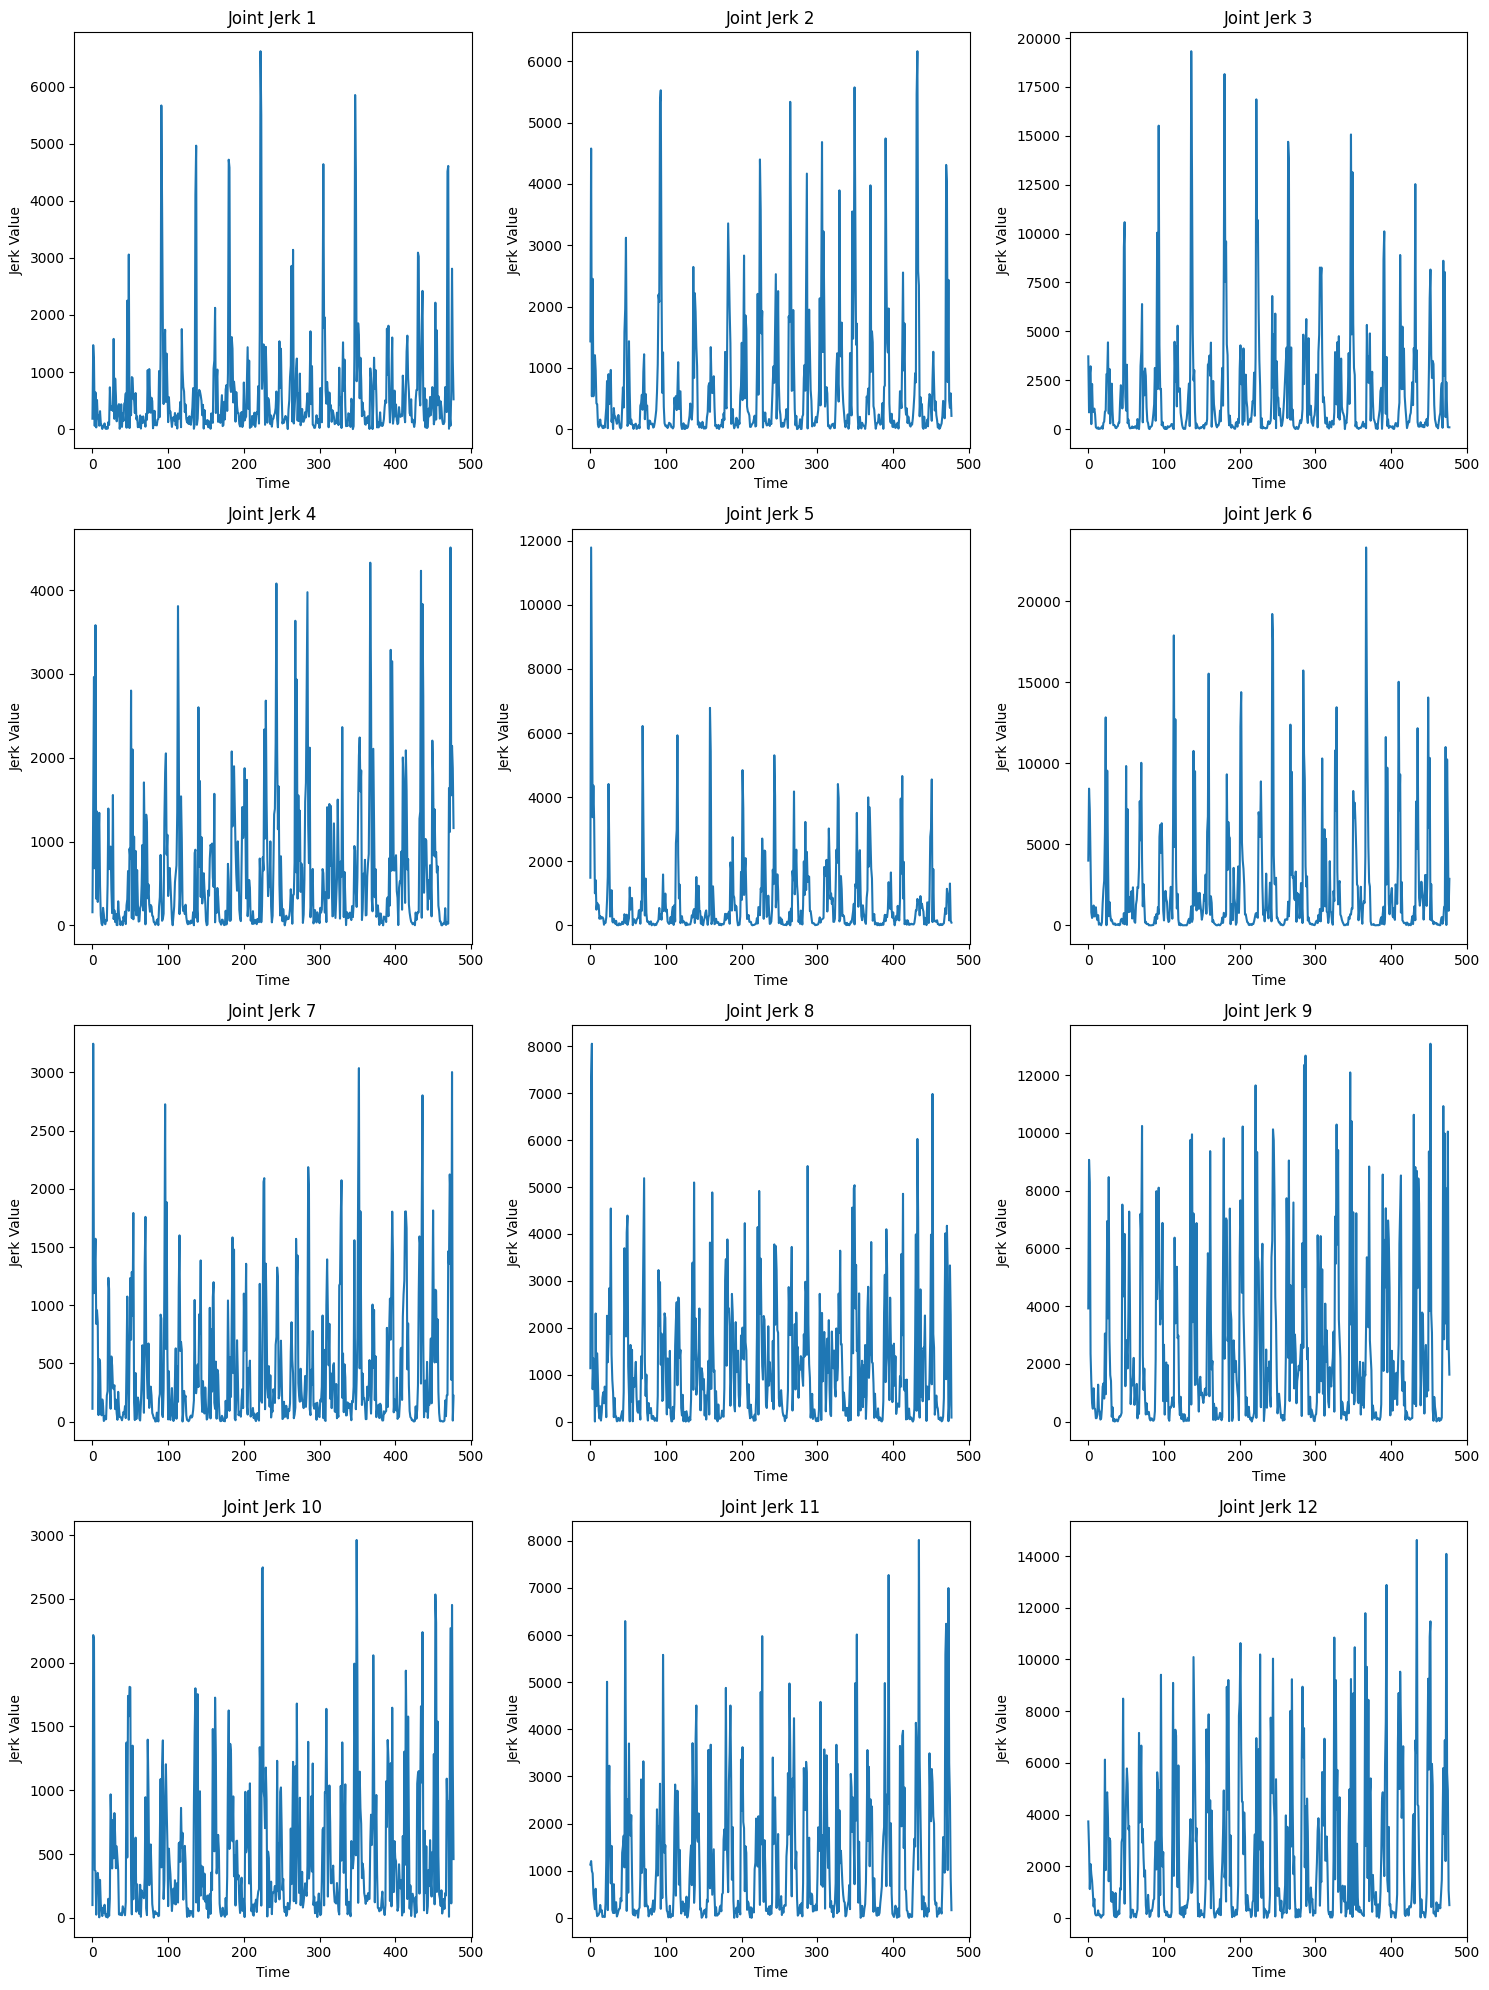

In [9]:
# Extract the joint jerk data over time
joint_jerk = np.array(controller.hist_data["joint_jerk"])[:, 0]

# Number of data points in joint_jerk
n_data_points = len(joint_jerk)

# Number of joints (assuming the second dimension corresponds to joints)
num_joints = joint_jerk.shape[1]

# Number of columns per row in the subplot grid
n_cols = 3
# Number of rows needed for the grid
n_rows = int(np.ceil(num_joints / n_cols))

# Create the figure and axes for subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Plot the joint jerk data for each joint
for i in range(num_joints):
    axes[i].plot(joint_jerk[:, i])
    axes[i].set_title(f'Joint Jerk {i+1}')
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Jerk Value')

# Hide any unused subplots
for i in range(num_joints, len(axes)):
    fig.delaxes(axes[i])

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


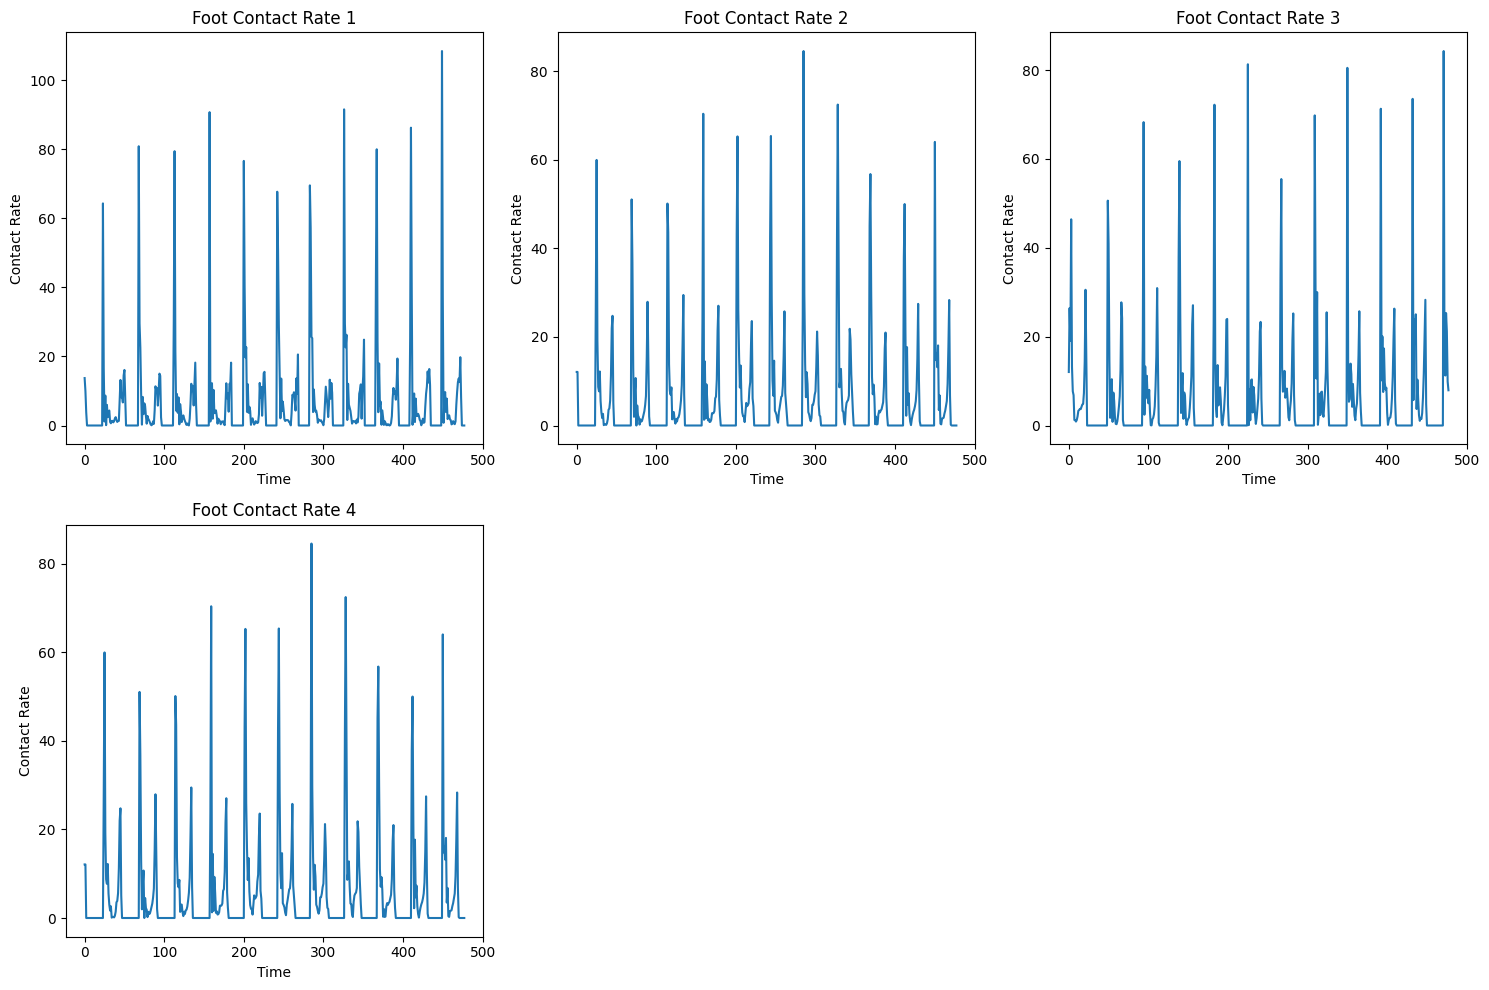

In [10]:
# Extract the foot contact rate data over time
foot_contact_rate = np.array(controller.hist_data["foot_contact_rate"])[:, 0]

# Number of data points in foot_contact_rate
n_data_points = foot_contact_rate.shape[0]

# Number of feet (assuming the second dimension corresponds to feet)
num_feet = foot_contact_rate.shape[1]

# Number of columns per row in the subplot grid
n_cols = 3
# Number of rows needed for the grid
n_rows = int(np.ceil(num_feet / n_cols))

# Create the figure and axes for subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Plot the foot contact rate data for each foot
for i in range(num_feet):
    axes[i].plot(foot_contact_rate[:, i])
    axes[i].set_title(f'Foot Contact Rate {i+1}')
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Contact Rate')

# Hide any unused subplots
for i in range(num_feet, len(axes)):
    fig.delaxes(axes[i])

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


## Test on Real Robot (ToDo)

In [1]:
from Go2Py.robot.fsm import FSM
from Go2Py.robot.remote import XBoxRemote
from Go2Py.robot.safety import SafetyHypervisor
from Go2Py.control.cat import *

pygame 2.6.1 (SDL 2.28.4, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
from Go2Py.robot.interface import GO2Real
import numpy as np
robot = GO2Real(mode='lowlevel')

In [3]:
robot.getJointStates()

{'q': [-0.058897197246551514,
  1.3202357292175293,
  -2.79561448097229,
  0.09329245984554291,
  1.3478487730026245,
  -2.8077938556671143,
  -0.395679235458374,
  1.2776601314544678,
  -2.820889472961426,
  0.3574388027191162,
  1.2831705808639526,
  -2.799926996231079],
 'dq': [0.003875523805618286,
  -0.01937761902809143,
  0.03033018670976162,
  0.007751047611236572,
  0.03875523805618286,
  -0.012132074683904648,
  -0.03875523805618286,
  0.01937761902809143,
  0.016176098957657814,
  -0.03100419044494629,
  0.09301257133483887,
  -0.044484272599220276],
 'tau_est': [-0.12369140982627869,
  0.12369140982627869,
  -0.23707520961761475,
  -0.07421484589576721,
  -0.14842969179153442,
  0.3319052755832672,
  0.049476563930511475,
  0.024738281965255737,
  -0.04741504043340683,
  0.07421484589576721,
  -0.14842969179153442,
  0.09483008086681366],
 'temperature': [31.0,
  29.0,
  30.0,
  29.0,
  29.0,
  30.0,
  31.0,
  29.0,
  30.0,
  31.0,
  30.0,
  30.0]}

Make sure the robot can take commands from python. The next cell should make the joints free to move (no damping).

In [4]:
import numpy as np
import time
start_time = time.time()

while time.time()-start_time < 10:
    q = np.zeros(12) 
    dq = np.zeros(12)
    kp = np.ones(12)*0.0
    kd = np.ones(12)*0.0
    tau = np.zeros(12)
    tau[0] = 0.0
    robot.setCommands(q, dq, kp, kd, tau)
    time.sleep(0.02)

In [4]:
remote = XBoxRemote() # KeyboardRemote()
safety_hypervisor = SafetyHypervisor(robot)

Put your stick at reset and do not touch it while calibrating


In [5]:
class CaTController:
    def __init__(self, robot, remote, checkpoint):
        self.remote = remote
        self.robot = robot
        self.policy = Policy(checkpoint)
        self.command_profile = CommandInterface()
        self.agent = CaTAgent(self.command_profile, self.robot)
        self.init()
        self.hist_data = {}

    def init(self):
        self.obs = self.agent.reset()
        self.policy_info = {}
        self.command_profile.yaw_vel_cmd = 0.0
        self.command_profile.x_vel_cmd = 0.0
        self.command_profile.y_vel_cmd = 0.0

    def update(self, robot, remote):
        commands = remote.getCommands()
        self.command_profile.yaw_vel_cmd = -commands[2]
        self.command_profile.x_vel_cmd = max(commands[1] * 0.5, -0.3)
        self.command_profile.y_vel_cmd = -commands[0]

        action = self.policy(self.obs, self.policy_info)
        self.obs, self.ret, self.done, self.info = self.agent.step(action)
        for key, value in self.info.items():
            if key in self.hist_data:
                self.hist_data[key].append(value)
            else:
                self.hist_data[key] = [value]

In [6]:
from Go2Py import ASSETS_PATH 
import os
checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/SoloParkour/trainparamsconfigmax_epochs1500_taskenvlearnlimitsfoot_contact_force_rate60_soft_07-20-22-43.pt')
controller = CaTController(robot, remote, checkpoint_path)

Exported model has been tested with ONNXRuntime, and the result looks good!
p_gains: [20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20.]


/home/Go2py/Go2Py/control/cat.py:100: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  actor_sd = torch.load(checkpoint_path, map_location="cpu")


In [10]:
fsm = FSM(robot, remote, safety_hypervisor, control_dT=1./50., user_controller_callback=controller.update)

In [9]:
fsm.close()